#### mUP

In [20]:
# See https://huggingface.co/datasets/datablations/mup
params = [200e6, 800e6, 1e9, 2e9, 2.5e9, 3e9, 3.5e9]
actual_params = [203668480, 709326848, 1516975104, 1766073088, 2626613248, 2951208704, 3294678528]
losses = [6.5364, 6.461173057556152, 6.468602657318115, 6.4994, 6.969681739807129, 6.870556831359863, 6.883823394775391]
losses_sp = [6.0892, 6.1391, 6.1667, 6.2378, 6.8899, 6.8162, 6.9612]

In [21]:
import numpy as np
#a, b, e, alpha, beta = [6.007337896264272, 6.016157159698354, 0.5247285289349821, 0.34, 0.28] # MW
a, b, e, alpha, beta = [6.255414, 7.3049974, 0.6254804, 0.3526596, 0.3526596]

A = np.exp(a)
B = np.exp(b)
E = np.exp(e)
G = ((alpha*A)/(beta*B))**(1/(alpha+beta))

def optimal_N(C):
    a = (beta)/(alpha+beta)
    N_opt = G*(C/6)**a
    return N_opt

def N_to_C(N):
    a = (beta)/(alpha+beta)
    C = ((N/G) ** (1/a)) * 6
    return C
  
def optimal_D(C):
    b = (alpha)/(alpha+beta)
    D_opt = (1/G)*(C/6)**b
    return D_opt

def D_to_C(D):
    b = (alpha)/(alpha+beta)
    C = ((G*D) ** (1/b)) * 6
    return C

def loss_fn(N, D):
    L = E + A/(N**alpha) + B/(D**beta)
    return L


func = r"$L(N,D,EP,NP)=E + \frac{A}{(UN + UN * N^* * (1 - e^{(-1*NP/(N^*))}))^\alpha} + \frac{B}{(U + U * EP^* * (1 - e^{(-1*EP/(EP^*))}))^\beta}$"
params_dc = [6.255414, 7.3049974, 0.6254804, 0.3526596, 0.3526596, 15.387756, 5.309743]

def scaling_law(N, D, U, params):
    a, b, e, alpha, beta, ep_star, n_star  = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)

    EP = np.maximum((D / U) - 1, 0)
    UN = np.minimum(N,optimal_N(D_to_C(U)))
    NP = np.maximum((N / UN ) - 1, 0)

    L = E + A/(UN + UN*n_star*(1-np.exp(-1*NP/n_star)))**alpha + B / (U + U * ep_star * (1 - np.exp(-1*EP/(ep_star))))**beta
    return L

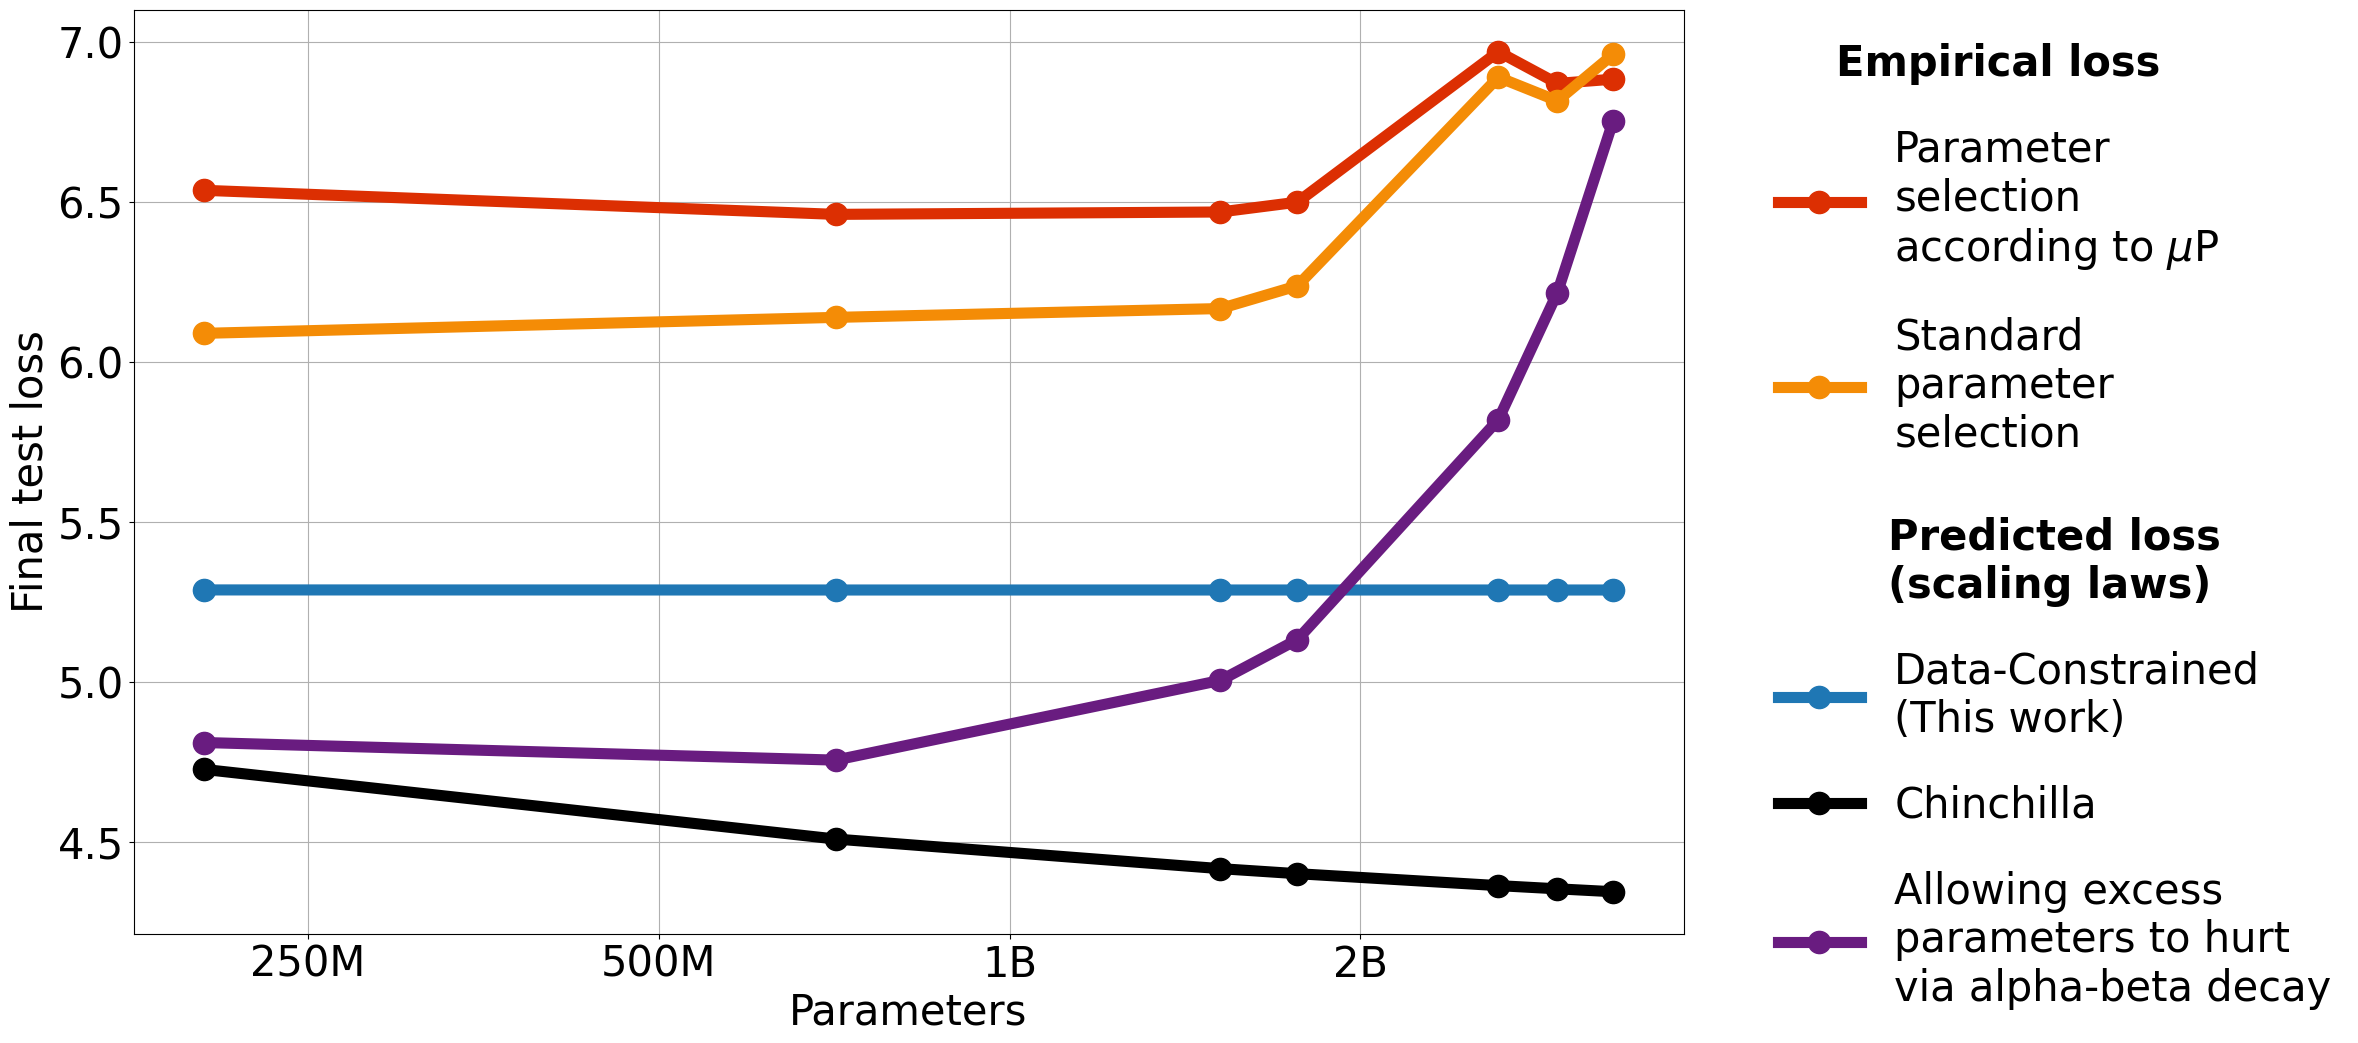

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Convert params to log scale
params = np.log10(actual_params)

FONTSIZE = 24 + 6

plt.figure(figsize=(20, 12))

plt.xticks(
    np.log10([250e6, 500e6, 1e9, 2e9, 10e9]), 
    ["250M", "500M", "1B", "2B", "10B"],
)


# Create a plot
mup_lines = plt.plot(params, losses, label="Maximal Update Parametrization (muP)", linewidth=8.0, marker=".", markersize=32, color="#DC2F02")
sp_lines = plt.plot(params, losses_sp, label="Standard Parametrization", linewidth=8.0, marker=".", markersize=32, color="#F48C06")
cc_lines = plt.plot(params, [loss_fn(10**p, 100e6) for p in params], label="Chinchilla Scaling Laws", linewidth=8.0, marker=".", markersize=32, color="black")
dc_lines = plt.plot(params, [scaling_law(10**p, 100e6, 100e6, params_dc) for p in params], label="Our Scaling Laws", linewidth=8.0, marker=".", markersize=32, color="#1f77b4")


def scaling_law(N, D, U, params):
    a, b, e, alpha, beta, ep_star, n_star = params

    EP = np.maximum((D / U) - 1, 0)
    UN = np.minimum(N,optimal_N(D_to_C(U)))
    NP = np.maximum((N / UN ) - 1, 0)

    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    L = E + A/(N**(alpha * np.maximum(np.zeros_like(NP), 1 - (NP/n_star)))) + B / (D**(beta * np.maximum(np.zeros_like(EP), 1 - (EP/ep_star))))
    return L

params_ab = [6.255414, 7.3049974, 0.6254804, 0.3526596, 0.3526596, 26530.611, 2040.8163]

ab_lines = plt.plot(params, [scaling_law(10**p, 100e6, 100e6, params_ab) for p in params], label="ab decay", linewidth=8.0, marker=".", markersize=32, color="#691C80")


# Set the x-axis label
plt.xlabel('Parameters', fontsize=FONTSIZE,)

# Set the y-axis label
plt.ylabel('Final test loss', fontsize=FONTSIZE,)

plt.legend(
    frameon=True,
    fontsize=FONTSIZE,

)

legend1 = plt.legend(
    [mup_lines[0], sp_lines[0]], ["Parameter\nselection\n"+ r"according to $\mu$P", "Standard\nparameter\nselection"], 
    frameon=False,
    fontsize=FONTSIZE,
    ncol=1,
    loc=(1.05, 0.5), #     loc="center right",
    title="Empirical loss",
    title_fontproperties={'weight': 'bold', "size": FONTSIZE},
    labelspacing=1.05,
)
plt.legend(
    [dc_lines[0], cc_lines[0], ab_lines[0]], ["Data-Constrained\n(This work)", "Chinchilla", "Allowing excess\nparameters to hurt\nvia alpha-beta decay"], 
    frameon=False,
    fontsize=FONTSIZE,
    ncol=1,
    loc=(1.05, -0.1), # loc="center right",
    title="Predicted loss\n(scaling laws)",
    title_fontproperties={'weight': 'bold', "size": FONTSIZE},
    labelspacing=1.05,
)
plt.gca().add_artist(legend1)

plt.tick_params(labelsize=FONTSIZE)#, pad=16)
plt.tick_params(labelsize=FONTSIZE)#, pad=)


plt.grid()

#plt.title("Variably-sized models trained on 100M tokens for a single epoch")

plt.savefig(f"mup.pdf", bbox_inches="tight")

plt.show()

In [7]:
cc_lines[0]

#### Data Loading

In [ ]:
### DATA POINTS ###

# Read from the Log / TensorBoard of "val" designated folder of each model on the hub
NAMES_TO_VAL_LOSSES = {
    "2b84b4b": 3.265024E+00,
    "2b88b4b": 2.995093E+00,
    "2b812b4b": 2.884387E+00,
    "2b816b4b": 2.823208E+00,
    "2b824b4b": 2.752407E+00,
    "2b832b4b": 2.722962E+00,
    "2b840b4b": 2.706547E+00,
    
    # "2b855b4bc4optv1": 2.700284E+00,
    # "2b855b9boptv1": 2.632432E+00,
    # "2b855b9bc4opt2": 2.609009E+00
    # "2b855b4bc4opt2": 2.689857E+00,


    "2b855b11bc4seed1": 2.599277E+00,
    "2b855b11bc4seed2": 2.599763E+00,
    "2b855b11bc4seed3": 2.600254E+00,
    "2b855b11bc4seed4": 2.598042E+00,

    "2b855b14bc4seed1": 2.592292E+00,
    "2b855b14bc4seed2": 2.590478E+00,
    "2b855b14bc4seed3": 2.588968E+00,
    "2b855b14bc4seed4": 2.591426E+00,

    "2b855b18bc4seed1": 2.582283E+00,
    "2b855b18bc4seed2": 2.581189E+00,
    "2b855b18bc4seed3": 2.584074E+00,
    "2b855b18bc4seed4": 2.581949E+00,

    "2b855b1b25c4seed1": 3.425332E+00,
    "2b855b1b25c4seed2": 3.422794E+00,
    "2b855b1b25c4seed3": 3.425154E+00,
    "2b855b1b25c4seed4": 3.428524E+00,


    "2b855b28bc4seed1": 2.575713E+00,
    "2b855b28bc4seed2": 2.576707E+00,
    "2b855b28bc4seed3": 2.574265E+00,
    "2b855b28bc4seed4": 2.575176E+00,

    "2b855b4bc4seed1": 2.693317E+00,
    "2b855b4bc4seed2": 2.691274E+00,
    "2b855b4bc4seed3": 2.692641E+00,
    "2b855b4bc4seed4": 2.692532E+00,

    "2b855b55bc4seed1": 2.569702E+00,
    "2b855b55bc4seed2": 2.568221E+00,
    "2b855b55bc4seed3": 2.569587E+00,
    "2b855b55bc4seed4": 2.570589E+00,

    "2b855b9bc4seed1": 2.609228E+00,
    "2b855b9bc4seed2": 2.605090E+00,
    "2b855b9bc4seed3": 2.605155E+00,
    "2b855b9bc4seed4": 2.606114E+00,

    #"2b855b55bperplexity": 2.604075E+00
    #"2b855b55bdedup": 2.758145E+00,

    # "2b884b84bperplexity25": 2.701157E+00
    # "2b884b84bperplexity50": 2.636081E+00
    # "2b884b84bperplexity2575": 2.612976E+00


    "2b855b1b25": 3.422766E+00,
    "2b855b4b": 2.696432E+00,
    "2b855b9b": 2.611045E+00,
    "2b855b11b": 2.598793E+00,
    "2b855b14b": 2.589427E+00,
    "2b855b18b": 2.584592E+00,
    "2b855b28b": 2.579361E+00,
    "2b855b55b": 2.574117E+00,

    "4b212b12b": 2.848890E+00,
    "4b224b12b": 2.691483E+00,
    "4b236b12b": 2.618343E+00,
    "4b248b12b": 2.577519E+00,
    "4b260b12b": 2.560390E+00,
    "4b272b12b": 2.539524E+00,

    # "4b284b12bsubopt": 2.562510E+00,
    # "4b284b6bsubopt": 2.650107E+00, # Probably worse cuz loss midway goes up (verify in graph)
    # "4b284b12bopt": 2.525244E+00,
    # "4b284b6bopt": 2.641864E+00
    

    "4b284b12bseed1": 2.538173E+00,
    "4b284b12bc4seed2": 2.526042E+00,
    "4b284b12bc4seed3": 2.537281E+00,
    "4b284b12bc4seed4": 2.527790E+00,

    "4b284b17bc4seed1": 2.549558E+00,
    "4b284b17bc4seed2": 2.503345E+00,
    "4b284b17bc4seed3": 2.499933E+00,
    "4b284b17bc4seed4": 2.496040E+00,

    "4b284b1b9c4seed1": 3.118388E+00,
    "4b284b1b9c4seed2": 3.082603E+00,
    "4b284b1b9c4seed3": 3.111291E+00,
    "4b284b1b9c4seed4": 3.146578E+00,

    "4b284b21bc4seed1": 2.502885E+00,
    "4b284b21bc4seed2": 2.480593E+00,
    "4b284b21bc4seed3": 2.491781E+00,
    "4b284b21bc4seed4": 2.477816E+00,

    "4b284b28bc4seed1": 2.479697E+00,
    "4b284b28bc4seed2": 2.482804E+00,
    "4b284b28bc4seed3": 2.477427E+00,
    "4b284b28bc4seed4": 2.494708E+00,

    "4b284b42bc4seed1": 2.470463E+00,
    "4b284b42bc4seed2": 2.491261E+00,
    "4b284b42bc4seed3": 2.469242E+00,
    "4b284b42bc4seed4": 2.469873E+00,

    "4b284b84bc4v2seed1": 2.464149E+00,
    "4b284b84bc4v2seed2": 2.461136E+00,
    "4b284b84bc4v2seed3": 2.480773E+00,
    "4b284b84bc4v2seed4": 2.476263E+00,

    "4b284b6bseed1": 2.602034E+00, 
    "4b284b6bseed2": 2.604310E+00,
    "4b284b6bseed3": 2.609000E+00,
    "4b284b6bseed4": 2.614594E+00,

    #"4b284b84b10c4py": 2.813708E+00,
    #"4b284b84b20c4py": 2.683304E+00
    #"4b284b84b30c4py": 2.613236E+00,
    #"4b284b84b40c4py": 2.568575E+00,
    #"4b284b84b50c4py": 2.535289E+00,
    #"4b284b84b60c4py": 2.509820E+00,
    #"4b284b84b70c4py": 2.491829E+00,
    #"4b284b84b80c4py": 2.479359E+00,
    #"4b284b84b90c4py": 2.462060E+00,

    "4b284b1b9": 3.276627E+00,
    "4b284b6b": 2.639410E+00,
    "4b284b12b": 2.526961E+00,
    "4b284b17b": 2.485060E+00,
    "4b284b21b": 2.471375E+00,
    "4b284b28b": 2.467156E+00,
    "4b284b42b": 2.470016E+00,
    "4b284b84b": 2.456530E+00,

    "8b7178b25b": 2.376484E+00,
    "8b7178b35b": 2.360029E+00,
    "8b7178b44b": 2.351177E+00,
    "8b7178b58b": 2.348107E+00,
    "8b7178b88b": 2.337275E+00,
    "8b7178b178b": 2.336741E+00,


    "7m100m100m": 8.107364E+00, # MassiveW optimal one
    "7m200m100m": 7.362360E+00,

    "1b1100m100m": 6.611002E+00,
    "2b8100m100m": 7.518863E+00,

    "14m100m100m": 7.278144E+00, # C4 optimal one
    "20m400m400m": 6.096268E+00,
    "25m400m400m": 5.794130E+00, # MassiveW optimal one
    
    "25m200m100m": 6.252892E+00,
    "25m400m100m": 5.799587E+00,
    "25m800m100m": 5.284175E+00,

    "14m200m100m": 6.664138E+00,
    "14m400m100m": 6.273184E+00,
    "14m800m100m": 5.816824E+00,

    "14m1b5100m": 5.364749E+00,
    "14m2b7100m": 4.992776E+00,
    "14m3b9100m": 4.741132E+00,
    "14m5b9100m": 4.546227E+00,
    "14m7b5100m": 4.472296E+00,
    "14m14b100m": 4.383392E+00,
    "14m20b100m": 4.510410E+00, ### DOUBLE DESCENT ###
    "14m91b100m": 4.396074E+00,
    "14m174b100m": 4.359691E+00,
    "14m300b100m": 4.369110E+00, ### DOUBLE DESCENT ###
    "14m600b100m": 4.331469E+00,
    "14m900b100m": 4.304018E+00, # 3362566

    "44m200m100m": 6.189970E+00,
    "44m400m100m": 5.648868E+00,

    "44m1b5100m": 4.387672E+00,
    "44m2b7100m": 4.113597E+00,
    "44m3b9100m": 3.988205E+00,
    "44m5b9100m": 3.894340E+00,
    "44m7b5100m": 3.854261E+00,
    "44m14b100m": 3.807672E+00,
    "44m20b100m": 3.929030E+00, ### DOUBLE DESCENT ###
    "44m32b100m": 3.892240E+00,
    "44m91b100m": 3.836200E+00,
    "44m174b100m": 3.812315E+00,

    "83m1b51b5": 4.362080E+00, # MassiveW optimal one

    "196m1b51b5": 3.929866E+00, # C4 optimal one

    "1b11b51b5": 3.680017E+00,
    "1b11b5400m": 3.704141E+00,
    "1b11b5100m": 3.819042E+00,

    "1b12b7100m": 4.097820E+00,
    "1b13b9100m": 4.834920E+00,
    "1b15b9100m": 6.013517E+00,
    "1b17b5100m": 6.742290E+00,

    "619m2b72b7": 3.415532E+00,
    "619m2b71b5": 3.409955E+00,
    "619m2b7400m": 3.449187E+00,
    "619m2b7100m": 3.829336E+00,

    "619m1b5100m": 3.784308E+00,
    "619m3b9100m": 4.152834E+00,
    "619m5b9100m": 4.668028E+00,
    "619m7b5100m": 5.001218E+00,

    "421m3b93b9": 3.348126E+00,
    "421m3b91b5": 3.354960E+00,
    "421m3b9400m": 3.404755E+00,
    "421m3b9100m": 3.898620E+00,

    "421m1b5100m": 3.797898E+00,
    "421m2b7100m": 3.747371E+00,
    "421m5b9100m": 4.169935E+00,
    "421m7b5100m": 4.376178E+00,

    "280m5b95b9": 3.319542E+00,
    "280m5b91b5": 3.330755E+00,
    "280m5b9400m": 3.386692E+00,
    "280m5b9100m": 3.882211E+00,

    "280m1b5100m": 3.877228E+00,
    "280m2b7100m": 3.727590E+00,
    "280m3b9100m": 3.754965E+00,
    "280m7b5100m": 3.993410E+00,
    "280m91b400m": 3.312059E+00,

    "220m7b57b5": 3.310159E+00,
    "220m7b51b5": 3.325092E+00,
    "220m7b5400m": 3.374362E+00,
    "220m7b5100m": 3.848433E+00,

    "220m1b5100m": 3.932167E+00,
    "220m2b7100m": 3.752793E+00,
    "220m3b9100m": 3.721901E+00,
    "220m5b9100m": 3.780970E+00,

    "220m3b9100mdedup": 3.863982E+00,

    "146m14b14b": 3.319729E+00,
    "146m14b1b5": 3.334061E+00,
    "146m14b400m": 3.390927E+00,
    "146m14b100m": 3.801428E+00, ### DOUBLE DESCENT

    "146m60b400m": 3.340250E+00,
    "146m91b400m": 3.311519E+00,
    "146m174b400m": 3.277013E+00,

    "146m1b5100m": 4.033501E+00,
    "146m2b7100m": 3.807640E+00,
    "146m3b9100m": 3.732758E+00,
    "146m5b9100m": 3.718068E+00, # To FLOPS: 6 * 146M * 5.9B = 5.0622e+18
    "146m7b5100m": 3.735044E+00,
    "146m20b100m": 3.756257E+00,
    "146m32b100m": 3.793078E+00,
    "146m60b100m": 3.846421E+00,
    "146m91b100m": 3.862952E+00,
    "146m174b100m": 3.897418E+00,

    "146m1b5100mdedup": 4.169387E+00,
    "146m2b7100mdedup": 3.949182E+00,
    "146m3b9100mdedup": 3.871975E+00,
    "146m5b9100mdedup": 3.860607E+00,
    "146m7b5100mdedup": 3.883653E+00,
    "146m14b100mdedup": 3.963449E+00, # WEAK DOUBLE DESCENT
    "146m32b100mdedup": 3.962464E+00,
    "146m60b100mdedup": 4.017775E+00,
    "146m91b100mdedup": 4.065124E+00,
    "146m174b100mdedup": 4.094653E+00,

    "83m20b20b": 3.608018E+00,
    "83m20b1b5": 3.618937E+00,
    "83m20b400m": 3.651057E+00,
    "83m20b100m": 3.790125E+00, ### DOUBLE DESCENT ###

    "83m400m100m": 5.488318E+00,
    "83m1b5100m": 4.206960E+00,
    "83m2b7100m": 3.953894E+00,
    "83m3b9100m": 3.844048E+00,
    "83m5b9100m": 3.774708E+00,
    "83m7b5100m": 3.747734E+00,
    "83m14b100m": 3.725231E+00,
    "83m32b100m": 3.747091E+00,
    "83m60b100m": 3.747091E+00,
    "83m91b100m": 3.743505E+00,
    "83m174b100m": 3.734349E+00,
    "83m300b100m": 3.868704E+00,

    "83m14b100mdedup": 3.872943E+00,

    "2b84b84b8": 3.236253E+00,
    "2b84b81b5": 3.244249E+00,
    "2b84b8400m": 3.378791E+00,
    "2b84b8100m": 5.340819E+00,

    "1b58b88b8": 3.022525E+00,
    "1b58b84b8": 3.022745E+00,
    "1b58b81b5": 3.070052E+00,
    "1b58b8400m": 3.479142E+00,
    "1b58b8100m": 7.679766E+00,

    "1b112b12b": 2.925644E+00,
    "1b112b4b8": 2.927054E+00,
    "1b112b1b5": 2.996886E+00,
    "1b112b400m": 3.547616E+00,
    "1b112b100m": 8.136283E+00,

    "619m22b22b": 2.900172E+00,
    "619m22b4b8": 2.912009E+00,
    "619m22b1b5": 2.973545E+00, # To FLOPS: 6 * 619M * 22B = 8.1708e+19
    "619m22b400m": 3.441785E+00,
    "619m22b100m": 6.840158E+00,

    "619m60b400m": 3.688865E+00,
    "619m91b400m": 3.756154E+00,

    "421m32b32b": 2.912103E+00,
    "421m32b4b8": 2.926206E+00,
    "421m32b1b5": 2.980892E+00,
    "421m32b400m": 3.366502E+00,
    "421m32b100m": 5.783605E+00,

    "421m60b400m": 3.431953E+00,
    "421m91b400m": 3.465185E+00,

    "421m91b1b5": 2.917592E+00,
    "421m250b1b5": 2.890927E+00,
    "421m300b1b5": 2.884335E+00,

    "221m60b60b": 2.981407E+00,
    "221m60b4b8": 2.993185E+00, 
    "221m60b1b5": 3.032319E+00,
    "221m60b400m": 3.258704E+00,

    "221m3b9400m": 3.525297E+00, # 3427121
    "221m32b400m": 3.260515E+00,
    "221m91b400m": 3.261209E+00,
    "221m174b400m": 3.260720E+00,
    "221m300b400m": 3.257426E+00,
    "221m600b400m": 3.261908E+00, # 3427134

    "8b712b12b": 3.140306E+00,
    "8b712b1b5": 3.063302E+00,
    "8b712b400m": 4.538278E+00,
    "8b712b100m": 7.385309E+00,

    "3b926b26b": 2.916993E+00,
    "3b926b12b": 2.947956E+00,
    "3b926b1b5": 3.020170E+00,
    "3b926b400m": 0, # 3325633 || 3417346 || 3417449
    "3b926b100m": 0, # 3328544 || 3417450

    "2b836b36b": 2.618932E+00,
    "2b836b12b": 2.636968E+00,
    "2b836b1b5": 3.065092E+00,
    "2b836b400m": 6.548141E+00,
    "2b836b100m": 1.069564E+01,

    "2b246b46b": 2.603919E+00,
    "2b246b12b": 2.638341E+00,
    "2b246b1b5": 3.029574E+00,
    "2b246b400m": 5.896346E+00,
    "2b246b100m": 1.087606E+01,

    "1b566b66b": 2.592968E+00,
    "1b566b12b": 2.626113E+00,
    "1b566b1b5": 2.992921E+00,
    "1b566b400m": 0,
    "1b566b100m": 1.101838E+01,

    "1b191b91b": 2.636805E+00, ####
    "1b191b12b": 2.665932E+00, ####
    "1b191b400m": 4.618763E+00,
    "1b191b1b5": 2.939082E+00,

    "574m174b174b": 2.708514E+00,
    "574m174b12b": 2.738098E+00,
    "574m174b1b5": 2.895393E+00,
    "574m174b400m": 3.752652E+00,

    "220m200b1b5": 0, # Run 3329133 3329460 | 3361359
    "220m250b1b5": 0, # Run 3329465 | 3361350
    "220m300b1b5": 2.958765E+00, # 3319369 3329472 | 3361340
    "220m600b1b5": 2.937761E+00,
    "220m900b1b5": 0, # 3327278 3329479 | 3361319

    "574m200b1b5": 0, # Run | 3361309
    "574m250b1b5": 0, # Run 3319364 | 3361298
    "574m300b1b5": 2.881076E+00,
    "574m600b1b5": 2.863888E+00, # 3327301 | 3361285 (short) ||| 3420530

    "1b1174b1b5": 2.974257E+00, # Run
    "1b1250b1b5": 2.986145E+00,

    "1b591b1b5": 3.034805E+00,
    "1b5174b1b5": 3.099245E+00,

    "2b266b1b5": 0, # Run > 3325408
    "2b291b1b5": 3.176858E+00,
    "2b2174b1b5": 3.351022E+00,

    "8b720b1b5": 3.084724E+00,
    "2b877b1b5": 3.297776E+00,

}

TOKENS_MAP = {
    "100m": 0.1,
    "200m": 0.2,
    "400m": 0.4,
    "800m": 0.8,
    "1b25": 1.25,
    "1b5": 1.5,
    "1b9": 1.9,
    "2b7": 2.7,
    "2b8": 2.8,
    "3b9": 3.9,
    "5b9": 5.9,
    "7b5": 7.5,
    "14b": 14,
    "20b": 20,
    "174b": 174,    
}

PARAMS_MAP = {
    "7m": 7.098752E+06,
    "14m": 1.41E+07,
    "20m": 19.703712E+06,
    "25m": 35.5E+06,
    "44m": 4.4E+07,
    "83m": 8.27E+07,    
    "146m": 1.465E+08,
    "196m": 201.236224E+06,
    "220m": 2.205E+08,
    "221m": 2.205E+08,
    "280m": 2.81E+08,
    "421m": 4.212E+08,
    "574m": 573.7E+06,
    "619m": 6.187E+08,
    "1b1": 1.0963E+09,     
    "1b5": 1.5173E+09,
    "2b2": 2.160013824E+09,
    "2b8": 2.81E+09,    
    "3b8": 3.581186048E+09, # 3802M
    "3b9": 3.89971072E+09,
    "4b2": 4.2465E+09,
    "8b7": 8.67E+09,
}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

model_params = []
tokens = []
unique_tokens = []
losses = []
names = []
epochs = []

def get_params(name):
    idx = 2
    while name[:idx] not in PARAMS_MAP:
        idx += 1
    params = PARAMS_MAP[name[:idx]]

    return params, idx


def get_unique_tokens(name):
    idx = -4 if (name[-1] in ("b", "m")) or ((name[-1] not in ("b", "m")) and (name[-2] not in ("b", "m"))) else -3
    ut = name[idx:]
    while (ut.count("b") > 1) or (ut.count("m") > 1):
        idx += 1
        ut = name[idx:]
    if ut in TOKENS_MAP:
        ut = TOKENS_MAP[ut]
    else:
        ut = float(ut.replace("b", ".").strip("."))
    
    if name == "2b855b1b25":
      print(name[idx:])

    return ut * 1e9, idx

def get_tokens(tokens):
    if tokens in TOKENS_MAP:
        tokens = TOKENS_MAP[tokens]
    else:
        tokens = float(tokens.replace("b", ".").strip("."))

    return tokens * 1e9 # Defined in billions

for name, loss in NAMES_TO_VAL_LOSSES.items():
    if loss != 0 and not(name.endswith("dedup")) and not("seed" in name) and not("opt" in name):
        p, tok_start_idx = get_params(name)
        ut, tok_end_idx = get_unique_tokens(name)
        t = get_tokens(name[tok_start_idx:tok_end_idx])

        model_params.append(p)
        unique_tokens.append(ut)
        tokens.append(t)
        losses.append(loss)
        epochs.append(t/ut)

        names.append(name)

        print(name, p, t, ut, loss)



2b84b4b 2810000000.0 4000000000.0 4000000000.0 3.265024
2b88b4b 2810000000.0 8000000000.0 4000000000.0 2.995093
2b812b4b 2810000000.0 12000000000.0 4000000000.0 2.884387
2b816b4b 2810000000.0 16000000000.0 4000000000.0 2.823208
2b824b4b 2810000000.0 24000000000.0 4000000000.0 2.752407
2b832b4b 2810000000.0 32000000000.0 4000000000.0 2.722962
2b840b4b 2810000000.0 40000000000.0 4000000000.0 2.706547
1b25
2b855b1b25 2810000000.0 55000000000.0 1250000000.0 3.422766
2b855b4b 2810000000.0 55000000000.0 4000000000.0 2.696432
2b855b9b 2810000000.0 55000000000.0 9000000000.0 2.611045
2b855b11b 2810000000.0 55000000000.0 11000000000.0 2.598793
2b855b14b 2810000000.0 55000000000.0 14000000000.0 2.589427
2b855b18b 2810000000.0 55000000000.0 18000000000.0 2.584592
2b855b28b 2810000000.0 55000000000.0 28000000000.0 2.579361
2b855b55b 2810000000.0 55000000000.0 55000000000.0 2.574117
4b212b12b 4246500000.0 12000000000.0 12000000000.0 2.84889
4b224b12b 4246500000.0 24000000000.0 12000000000.0 2.69148

In [ ]:
for t, ut, m, l, n in zip(tokens, unique_tokens, model_params, losses, names):
    if ut > t:
        raise ValueError(n)

#### Double Descent

[15.0, 27.0, 39.0, 59.0, 75.0, 140.0, 200.0, 910.0, 1740.0, 3000.0, 6000.0, 9000.0]


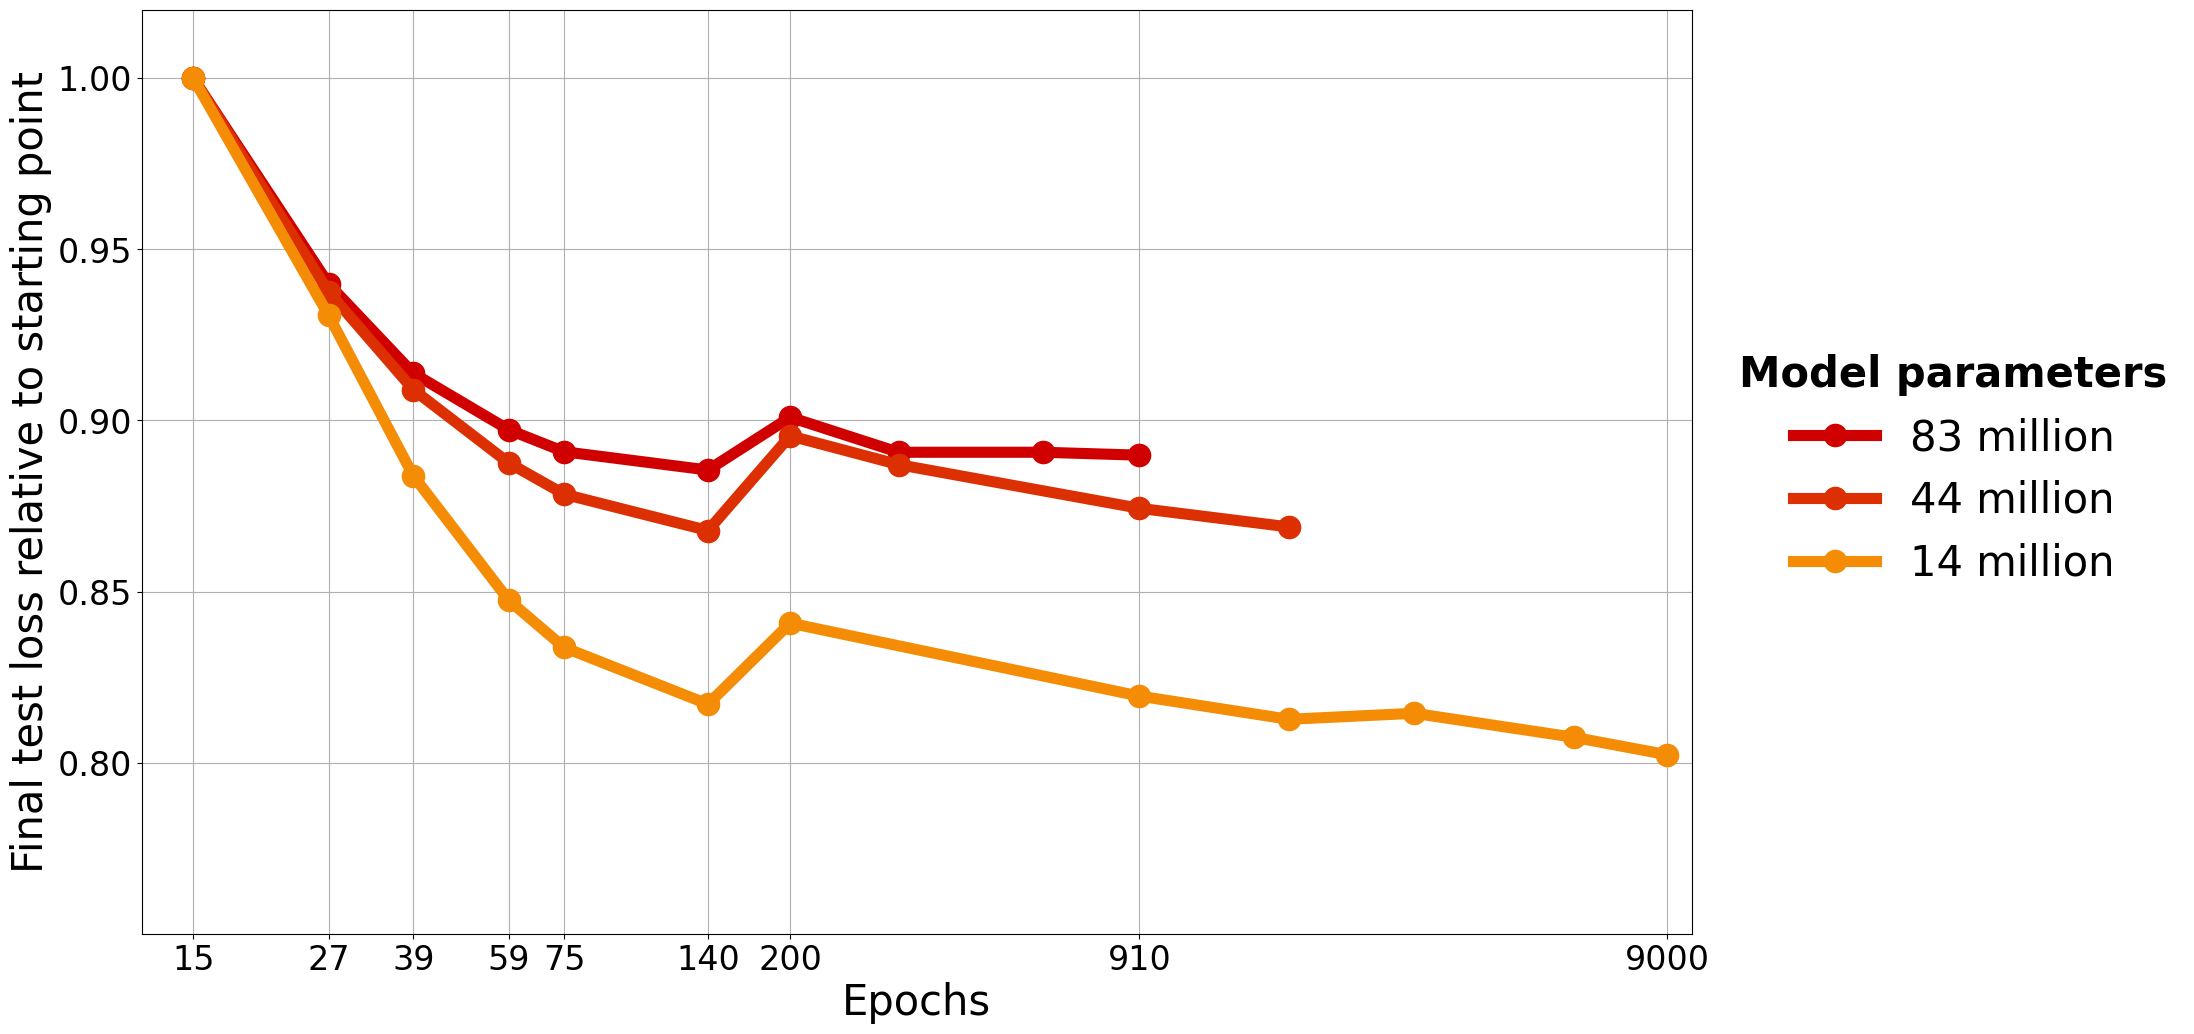

In [ ]:
### Relative loss as y & num epochs trained for as x

from matplotlib.cm import unregister_cmap
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

random.seed(42)
np.random.seed(42)

FONTSIZE = 24 + 6
FONTSIZE_SMALL = 16 + 8

# Create the contour plot
plt.figure(figsize=(20, 12))

EPOCHS_TO_COLOR = {
    44: "#03071E",
    14: "#6A040F",
    7: "#D00000",
    5: "#DC2F02",
    4: "#E85D04",
    3: "#F48C06",
    2: "#FAA307",
    1: "#FFBA08",
}




x_ticks = [14.999999999999993, 26.99999999999999, 38.999999999999986, 58.99999999999997, 74.99999999999997, 139.99999999999994, 199.99999999999991, 909.9999999999995, 9000]
x_ticks_loc = [np.log10(x) for x in x_ticks]
plt.xticks(x_ticks_loc, [round(x) for x in x_ticks])

plt.xlabel('Epochs', fontsize=FONTSIZE)
plt.ylabel('Final test loss relative to starting point', fontsize=FONTSIZE)

plt.yticks([0.8, 0.85, 0.9, 0.95, 1.0])

plt.xlim(np.log10(12), np.log10(10000))
plt.ylim(0.75, 1.02)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE_SMALL)

"""
eps_x, loss_y = [], []
for n, e, p, pm, l, ut in zip(names, epochs, model_params, model_params, losses, unique_tokens):
    if (ut == 100e6) and (p == PARAMS_MAP["146m"]) and (e > 10):
        eps_x.append(e)
        loss_y.append(l)
loss_y = [x for _, x in sorted(zip(eps_x, loss_y))]
eps_x = sorted(eps_x)
print(eps_x)
loss_y = [x/loss_y[0] for x in loss_y]
plt.plot(np.log10(eps_x), loss_y, label="146 million", marker=".", color=EPOCHS_TO_COLOR[3], markersize=20)
"""


eps_x, loss_y = [], []
for n, e, p, pm, l, ut in zip(names, epochs, model_params, model_params, losses, unique_tokens):
    if (ut == 100e6) and (p == PARAMS_MAP["83m"]) and (e > 10) and (e < 950):
        eps_x.append(e)
        loss_y.append(l)
loss_y = [x for _, x in sorted(zip(eps_x, loss_y))]
eps_x = sorted(eps_x)
loss_y = [x/loss_y[0] for x in loss_y]
plt.plot(np.log10(eps_x), loss_y, label="83 million", marker=".", color=EPOCHS_TO_COLOR[7], markersize=32, linewidth=8)



# Plot 100M
eps_x, loss_y = [], []
for n, e, p, pm, l, ut in zip(names, epochs, model_params, model_params, losses, unique_tokens):
    if (ut == 100e6) and (p == PARAMS_MAP["44m"]) and (e > 10):
        eps_x.append(e)
        loss_y.append(l)
loss_y = [x for _, x in sorted(zip(eps_x, loss_y))]
eps_x = sorted(eps_x)
loss_y = [x/loss_y[0] for x in loss_y]
plt.plot(np.log10(eps_x), loss_y, label="44 million", marker=".", color=EPOCHS_TO_COLOR[5], markersize=32, linewidth=8)


# Plot 100M
eps_x, loss_y = [], []
for n, e, p, pm, l, ut in zip(names, epochs, model_params, model_params, losses, unique_tokens):
    if (ut == 100e6) and (p == PARAMS_MAP["14m"]) and (e > 10):
        eps_x.append(e)
        loss_y.append(l)
loss_y = [x for _, x in sorted(zip(eps_x, loss_y))]
eps_x = sorted(eps_x)
print(eps_x)
loss_y = [x/loss_y[0] for x in loss_y]
plt.plot(np.log10(eps_x), loss_y, label="14 million", marker=".", color=EPOCHS_TO_COLOR[3], markersize=32, linewidth=8)



eps_x, loss_y = [], []
for n, e, p, pm, l, ut in zip(names, epochs, model_params, model_params, losses, unique_tokens):
    if (ut == 100e6) and (p == 619000000.0):
        eps_x.append(e)
        loss_y.append(l)
loss_y = [x for _, x in sorted(zip(eps_x, loss_y))]
eps_x = sorted(eps_x)
#plt.plot(eps_x, loss_y, label="100M unique tokens & 619M params", marker=".")


# Plot 100M
eps_x, loss_y = [], []
for n, e, p, pm, l, ut in zip(names, epochs, model_params, model_params, losses, unique_tokens):
    if (ut == 100e6) and (p == 1100000000.0):
        eps_x.append(e)
        loss_y.append(l)
loss_y = [x for _, x in sorted(zip(eps_x, loss_y))]
eps_x = sorted(eps_x)


#plt.plot(eps_x, loss_y, label="100M unique tokens & 1B1 params", marker=".")


plt.legend(
    frameon=False,
    fontsize=FONTSIZE,
    title="Model parameters",
    title_fontproperties={'weight': 'bold', "size": FONTSIZE},
    columnspacing=0.9,
    loc=(1.02, 0.36),
    #ncol=4,
)


plt.grid()

plt.savefig(f"dd.pdf", bbox_inches="tight")


plt.show()


#### Dedup

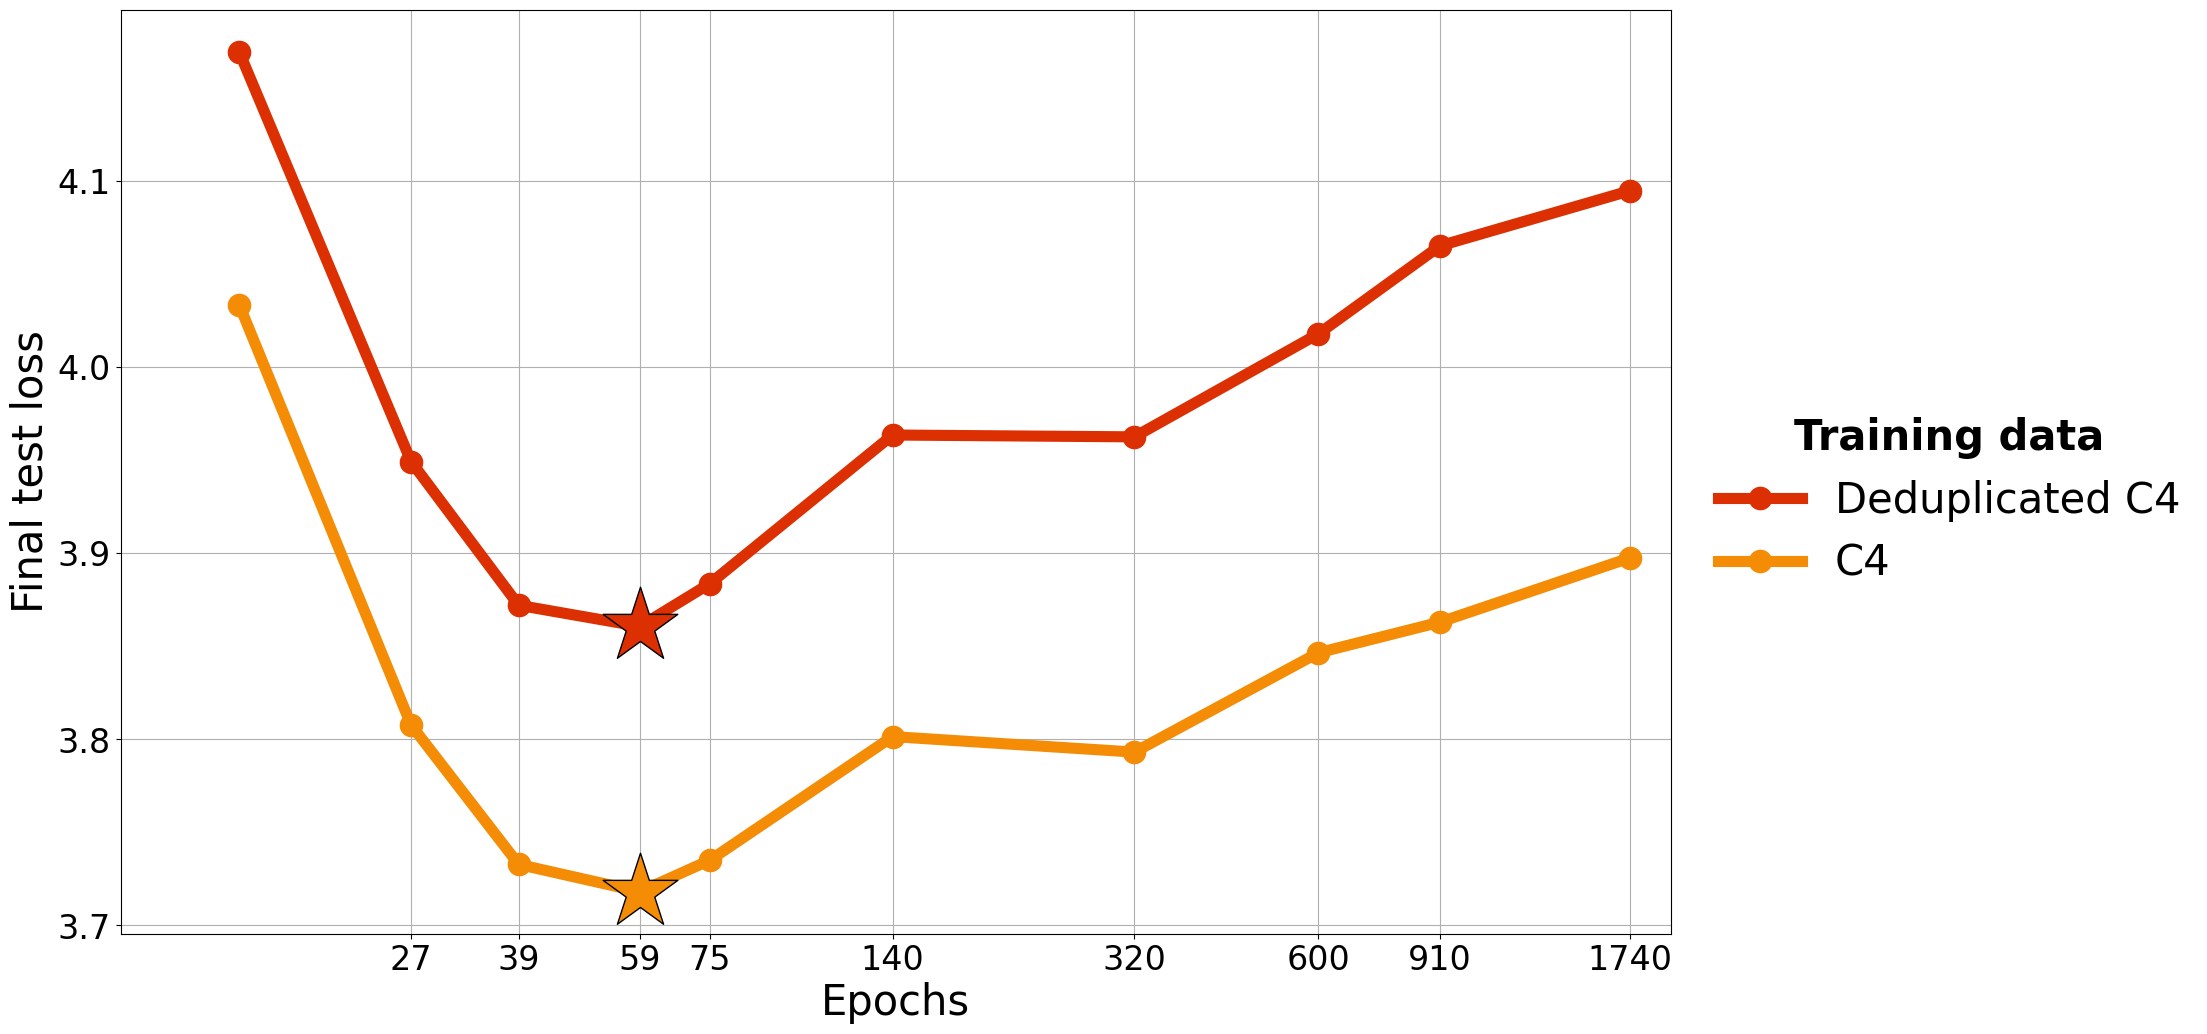

In [ ]:
dedup = {
      "146m2b7100mdedup": 3.949182E+00, # 3326957 3327355 3327412
      "146m3b9100mdedup": 3.871975E+00, # 3326484 3326914
      "146m5b9100mdedup": 3.860607E+00, # 3326401 3326911
      "146m7b5100mdedup": 3.883653E+00, # 3326482 3327350
      "146m14b100mdedup": 3.963449E+00, # 3326961  3328731 3328773 # WEAK DOUBLE DESCENT
      "146m32b100mdedup": 3.962464E+00, # 3326964 3328732
}    

dedup = {
    "146m1b5100mdedup": 4.169387E+00,
    "146m2b7100mdedup": 3.949182E+00,
    "146m3b9100mdedup": 3.871975E+00,
    "146m5b9100mdedup": 3.860607E+00,
    "146m7b5100mdedup": 3.883653E+00,
    "146m14b100mdedup": 3.963449E+00, # WEAK DOUBLE DESCENT
    "146m32b100mdedup": 3.962464E+00,
    "146m60b100mdedup": 4.017775E+00,
    "146m91b100mdedup": 4.065124E+00,
    "146m174b100mdedup": 4.094653E+00,
}

nondedup = {
      "146m2b7100m": 3.807640E+00,
      "146m3b9100m": 3.732758E+00,
      "146m5b9100m": 3.718068E+00, # To FLOPS: 6 * 146M * 5.9B = 5.0622e+18
      "146m7b5100m": 3.735044E+00,
      "146m14b100m": 3.801428E+00, ### DOUBLE DESCENT
      #"146m20b100m": 3.756257E+00,
      "146m32b100m": 3.793078E+00, # 3319436 3324348

}


nondedup = {
    "146m1b5100m": 4.033501E+00,
    "146m2b7100m": 3.807640E+00,
    "146m3b9100m": 3.732758E+00,
    "146m5b9100m": 3.718068E+00, # To FLOPS: 6 * 146M * 5.9B = 5.0622e+18
    "146m7b5100m": 3.735044E+00,
    "146m14b100m": 3.801428E+00, ### DOUBLE DESCENT
    #"146m20b100m": 3.756257E+00,
    "146m32b100m": 3.793078E+00,
    "146m60b100m": 3.846421E+00,
    "146m91b100m": 3.862952E+00,
    "146m174b100m": 3.897418E+00,
}


from matplotlib.cm import unregister_cmap
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

random.seed(42)
np.random.seed(42)

FONTSIZE = 24 + 6
FONTSIZE_SMALL = 16 + 8

plt.figure(figsize=(20, 12))


EPOCHS_TO_COLOR = {
    44: "#03071E",
    14: "#6A040F",
    7: "#D00000",
    5: "#DC2F02",
    4: "#E85D04",
    3: "#F48C06",
    2: "#FAA307",
    1: "#FFBA08",
}



x_ticks = [26.99999999999999,
 38.999999999999986,
 58.99999999999997,
 74.99999999999997,
 139.99999999999994,
 319.99999999999983,
 600,
 910,
 1740,
]
 
x_ticks_loc = [np.log10(x) for x in x_ticks]
plt.xticks(x_ticks_loc, [round(x) for x in x_ticks])

plt.xlabel('Epochs', fontsize=FONTSIZE)
plt.ylabel('Final test loss', fontsize=FONTSIZE)

#plt.yticks([0.8, 0.85, 0.9, 0.95, 1.0])

plt.xlim(np.log10(10), np.log10(2000))
#plt.ylim(0.8, 1.02)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE_SMALL)



loss_nd = []
loss_d = []
eps_x = []

for n in nondedup:
    idx = names.index(n)
    eps_x.append(epochs[idx])
    loss_nd.append(nondedup[n])
    loss_d.append(dedup[n+"dedup"])

plt.plot(np.log10(eps_x), loss_d, label="Deduplicated C4", marker=".", color=EPOCHS_TO_COLOR[5], markersize=32, linewidth=8)
plt.plot(np.log10(eps_x), loss_nd, label="C4", marker=".", color=EPOCHS_TO_COLOR[3], markersize=32, linewidth=8)

plt.scatter([np.log10(58.99999999999997)], [min(loss_d)], s=3200, marker='*', edgecolor="black", color=EPOCHS_TO_COLOR[5], zorder=10)
plt.scatter([np.log10(58.99999999999997)], [min(loss_nd)], s=3200, marker='*', edgecolor="black", color=EPOCHS_TO_COLOR[3], zorder=10)


plt.legend(
    frameon=False,
    fontsize=FONTSIZE,
    title="Training data",
    title_fontproperties={'weight': 'bold', "size": FONTSIZE},
    columnspacing=0.9,
    loc=(1.02, 0.36),
)


plt.grid()

plt.savefig(f"dedup.pdf", bbox_inches="tight")

plt.show()

